## Definitions

In [0]:

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
import random
from sklearn.metrics import accuracy_score
import torch.optim as optim

%matplotlib inline
!pip install barbar 
!pip install --upgrade efficientnet-pytorch
from barbar import Bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=522165297297acbf643838c667f0494288ed4b9ae08e096abc9f69fc9e74f5f2
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built efficientnet-pytorch


device(type='cuda')

## Loading and Unzipping the data

In [0]:
file_id_train = "1RVDwvX18SmiKUdlAitfXNp-jBQi5PAaO"
file_id_val = "1rlR-K3fHQ3o58Expp4OJ8pVLhAuxFUFm"

# Downloading script that helps in fetching files from google drive
!git clone https://github.com/chentinghao/download_google_drive.git
%cd download_google_drive

!python download_gdrive.py $file_id_train /content/train.tar.gz
!python download_gdrive.py $file_id_val /content/val.tar.gz

%cd /content/

!tar -xf train.tar.gz
!tar -xf val.tar.gz
!mkdir checkpoints

Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
/content/download_google_drive
1.24GB [00:13, 101MB/s] 
318MB [00:02, 113MB/s] 
/content


## Configuration Options and Hyper Parameters

In [0]:
# Directory Paths 
train_dir = '/content/train/'
val_dir = '/content/val/'
test_dir = '/content/test/'

# classes
classes = ['nevi','lesion']

# Test Split
test_split = False


# normalization values for pretrained on imagenet
mean_resnet = (0.485, 0.456, 0.406)
std_resnet = (0.229, 0.224, 0.225)


# mean and std for the pre-trained model being specified here
norm_mean = mean_resnet
norm_std = std_resnet

# Hyper Parameters
batch_size = 16
validation_batch_size = 10
test_batch_size = 10
height= 450
width = 600


## Populating the Test Directory
 Training Images = 2300 Per Class

 Validation Images = 400 Per Class
 
 Testing Images = 300 Per Class

In [0]:
if test_split == True:
  !mkdir -p /content/test/nv
  !mkdir -p /content/test/les

  # Making the total test size = 300
  len_val_per_class = 200
  len_train_per_class = 100

  # Validation Images Moving to Testing Directory
  nv_val_items = os.listdir(val_dir + '/nv')
  les_val_items = os.listdir(val_dir + '/les')
  random.shuffle(nv_val_items)
  random.shuffle(les_val_items)

  for i in range(len_val_per_class):
    os.system('mv ' + '/content/val/nv/' + nv_val_items[i] + ' /content/test/nv/' + str(i) +'.jpg')
    
  for i in range(len_val_per_class):  
    os.system('mv ' + '/content/val/les/' + les_val_items[i] + ' /content/test/les/' + str(i) +'.jpg')

  # Training Images Moving to Testing Directory
  nv_train_items = os.listdir(train_dir + '/nv')
  les_train_items = os.listdir(train_dir + '/les')
  random.shuffle(nv_train_items)
  random.shuffle(les_train_items)


  for i in range(len_train_per_class):
    os.system('mv ' + '/content/train/nv/' + nv_train_items[i] + ' /content/test/nv/t_' + str(i) +  '.jpg')
    
  for i in range(len_train_per_class):  
    os.system('mv ' + '/content/train/les/' + les_train_items[i] + ' /content/test/les/t_' + str(i) +  '.jpg')


  # Checking the Contents of the Testing Directory
  print(len(os.listdir('/content/test/les')))
  print(len(os.listdir('/content/test/nv')))


## Augmentation


In [0]:
# Specifying the Augmentation for the training Images
transform_train = transforms.Compose([
                    transforms.Resize((height,width)),
                    transforms.RandomAffine(90,shear=20,scale=(0.8,1.2)),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ColorJitter(brightness=(0.7,1.3),contrast=(0.7,1.3),saturation=(0.7,1.3)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

# Validation and Testing Transformations
transform_val = transforms.Compose([
                    transforms.Resize((height,width)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((height,width)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])
transform_val_test = transforms.Compose([
                    transforms.Resize((height,width)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

## Data Generators

In [0]:
# Datasets
traindataset = torchvision.datasets.ImageFolder(root= train_dir, transform=transform_train)
valdataset = torchvision.datasets.ImageFolder(root= val_dir,transform=transform_val)
testvaldataset = torchvision.datasets.ImageFolder(root= val_dir,transform=transform_val_test)

# Data Loaders
train_data_loader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(valdataset, batch_size=validation_batch_size, shuffle=False)
test_validation_data_loader = torch.utils.data.DataLoader(testvaldataset, batch_size=1, shuffle=False)
if test_split == True:
  testdataset = torchvision.datasets.ImageFolder(root= test_dir,transform=transform_test)
  test_data_loader = torch.utils.data.DataLoader(testdataset, batch_size=test_batch_size, shuffle=False)

## Checking Some Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 nevi,   nevi,  lesion,   nevi,  lesion,  lesion,  lesion,   nevi,   nevi,  lesion,  lesion,   nevi,  lesion,   nevi,   nevi,   nevi, 


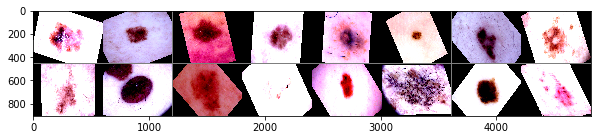

In [0]:

# functions to show an image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

# Architecture

In [0]:
from torch import nn
model = "densenet121"
num_classes = 2
net = torchvision.models.densenet121(pretrained = True)

# We replace last layer of resnet to match our number of classes which is 7
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 75.4MB/s]


### Metrics and Validation Evaluation

In [0]:

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

### Training Progress

In [0]:
load_checkpoint = False
choose_scheduler = False
print("Starting Training with Network: " + model + ", Choosing Scheduler Status: " + str(choose_scheduler) + ", Loading Checkpoint Status : " + str(load_checkpoint))

## Optimizer and Loss Configurations

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
#optimizer = optim.Adadelta(net.parameters())

if load_checkpoint == True:
  net.load_state_dict(torch.load('checkpoint.pt'))
  print("here")
patience_es = 20
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience_es, verbose=True)
# number of loops over the dataset
num_epochs = 100
accuracy = []
val_accuracy = []
losses = []
val_losses = []
best_accuracy = 0

if choose_scheduler:
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(Bar(train_data_loader)):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Training Loss: %.3f  , Training Accuracy:%.3f => Validation Loss: %.3f , Val Accuracy: %.3f ' %(running_loss, train_accuracy,val_loss, val_acc))

    losses.append(running_loss) # List containing the training losses
    val_losses.append(val_loss) # List containing the validation losses
    accuracy.append(train_accuracy) # List containing the training accuracy
    val_accuracy.append(val_acc) # list containing the validation accruacy
    if choose_scheduler:
      scheduler.step(val_loss)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(val_loss, net)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

print('Finished Training')

# Loading the best model
net.load_state_dict(torch.load('checkpoint.pt'))


Starting Training with Network: densenet121, Choosing Scheduler Status: False, Loading Checkpoint Status : False
4800/4800: [===============================>] - ETA 1.2s
Epoch: 1
Training Loss: 3.531  , Training Accuracy:0.571 => Validation Loss: 0.967 , Val Accuracy: 0.819 
Validation loss decreased (inf --> 0.967243).  Saving model ...
4800/4800: [===============================>] - ETA 0.9s
Epoch: 2
Training Loss: 0.426  , Training Accuracy:0.824 => Validation Loss: 0.326 , Val Accuracy: 0.860 
Validation loss decreased (0.967243 --> 0.326493).  Saving model ...
4800/4800: [===============================>] - ETA 0.9s
Epoch: 3
Training Loss: 0.340  , Training Accuracy:0.846 => Validation Loss: 0.309 , Val Accuracy: 0.871 
Validation loss decreased (0.326493 --> 0.308916).  Saving model ...
4800/4800: [===============================>] - ETA 0.9s
Epoch: 4
Training Loss: 0.317  , Training Accuracy:0.858 => Validation Loss: 0.284 , Val Accuracy: 0.873 
Validation loss decreased (0.3089

### Training and Validation Accuracy Curve

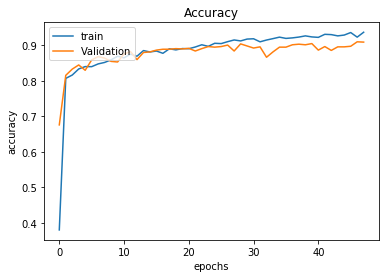

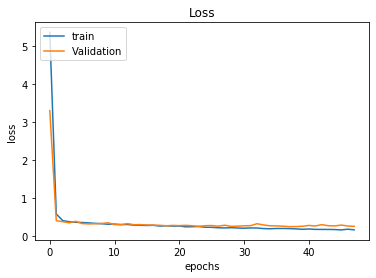

In [0]:

tmpdir = "/content/"
plt.figure()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'Validation'], loc='upper left')
plt.savefig("{}/accuracy.png".format(tmpdir))

# training and val loss
plt.figure()
plt.plot(losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'Validation'], loc='upper left')
plt.savefig("{}/loss.png".format(tmpdir))

### Testing Accuracy and Confusion Matrix

#### Validation Accuracy and Confusion Matrix without Test Time Augmentation

Accuracy of the network on the Validation images: 90 %
tensor([[555.,  45.],
        [ 72., 528.]])
0.9025


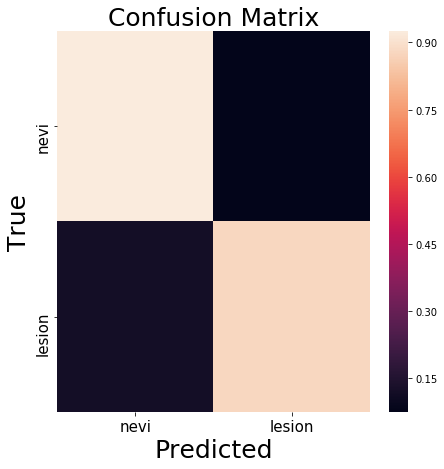

In [0]:
net.load_state_dict(torch.load('checkpoint.pt'))

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the Validation images: %d %%' % (
    100 * correct / total))

confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
cm = confusion_matrix.numpy()

fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['nevi','lesion'], size=15); 
ax.yaxis.set_ticklabels(['nevi','lesion'], size=15);
print(correct/total)

#### Validation and Testing Accuracy with Test Time Augmentation

In [0]:
net.load_state_dict(torch.load('checkpoint.pt'))


def apply_aug (image):
  #print("HI: ",image.shape)
  image = image.cpu().detach().numpy()
  #print(image.shape)


  image = np.squeeze(image)

  image = np.squeeze(np.swapaxes(np.expand_dims(image,-1),0,2))
  #plt.figure()
  #plt.imshow(image)
  #plt.show()
  image = (((image - np.min(image))/(np.max(image)-np.min(image))) * 255).astype("uint8")
  #plt.figure()
  #plt.imshow(image)
  #plt.show()

  #test = transforms.ToPILImage()
  image = Image.fromarray(image,'RGB')

 
  #image = test(image)
  test=transforms.RandomAffine(90,shear=20,scale=(0.8,1.2))
  image = test(image)
  test=transforms.RandomVerticalFlip()
  image = test(image)
  test = transforms.RandomHorizontalFlip()
  image = test(image)
  test = transforms.ColorJitter(brightness=(0.7,1.3),contrast=(0.7,1.3),saturation=(0.7,1.3))
  image = test(image)
  test = transforms.ToTensor()
  image = test(image)
  test=transforms.Normalize(norm_mean, norm_std)
  image = test(image)


  #print(image.shape)
  return image

correct = 0
total = 0
net.eval()
count = 0

with torch.no_grad():
    for data in test_validation_data_loader:
        count = count + 1
        print("Testing Image: ", count)
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        class0_count = 0
        class1_count = 0
        for i in range(32):
            temp = apply_aug(images)
            temp = temp.unsqueeze(0)
            temp = temp.to(device)
            outputs = net(temp)
            sm = torch.nn.Softmax()
            probabilities = sm(outputs) 
            #print("PREDICTED PROB: " ,probabilities) #Converted to probabilities
            _, predicted = torch.max(outputs.data, 1)
           
            if (predicted == 0):
              class0_count +=1
            else:
              class1_count +=1
            #print(outputs)
        print("0: ",class0_count,"1: ",class1_count)

        if class0_count > class1_count:
          predicted = 0
        else:
          predicted = 1
        print("################################################")    
        #_, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if (predicted == labels):
          print("CORRECT")
        else:
          print("FALSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")
        print("################################################")
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        if (predicted == labels):
          print("ACTUAL CORRECT")
        else:
          print("ACTUAL FALSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")
        print("################################################")
print('Accuracy of the network on the Validation images: %d %%' % (
    100 * correct / total))

print("ACCURACY: ",float(correct)/total)


Testing Image:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0:  32 1:  0
################################################
CORRECT
################################################
ACTUAL CORRECT
################################################
Testing Image:  2
0:  32 1:  0
################################################
CORRECT
################################################
ACTUAL CORRECT
################################################
Testing Image:  3
0:  32 1:  0
################################################
CORRECT
################################################
ACTUAL CORRECT
################################################
Testing Image:  4
0:  32 1:  0
################################################
CORRECT
################################################
ACTUAL CORRECT
################################################
Testing Image:  5
0:  32 1:  0
################################################
CORRECT
################################################
ACTUAL CORRECT
################################################
Testing Image